# Proyecto 3 

- Maria Luisa Rodriguez 202121549
- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 202212868

## Instalacion e importacion de librerias

In [1]:
!pip install deap
!pip install memory_profiler

In [2]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
from haversine import haversine
import requests
import itertools
import matplotlib.pyplot as plt
import folium

import time
from memory_profiler import memory_usage

## Funciones de apoyo

In [3]:
def get_route_info(lat1, lon1, lat2, lon2):
    base_url = "http://router.project-osrm.org/route/v1/driving/"
    coordinates = f"{lon1},{lat1};{lon2},{lat2}"
    url = base_url + coordinates
    params = {
        "overview": "full",
        "geometries": "geojson"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if "routes" in data and data["routes"]:
            route = data["routes"][0]
            distance = route["distance"] / 1000.0
            geometry = route["geometry"]["coordinates"]
            polyline = [[coord[1], coord[0]] for coord in geometry]
            return distance, polyline
        else:
            raise Exception("No se encontró una ruta.")
    except Exception as e:
        print("Error al obtener ruta vía OSRM:", e)
        fallback_distance = haversine((lat1, lon1), (lat2, lon2))
        fallback_polyline = [[lat1, lon1], [lat2, lon2]]
        return fallback_distance, fallback_polyline


In [4]:
def calcular_distancias_y_geometrias(centros, clientes, get_route_info):
    all_nodes = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    for i in all_nodes:
        for j in all_nodes:
            if i != j and not (i in centros and j in centros):
                # Obtener coordenadas de i
                if i in centros:
                    lat_i, lon_i = centros[i]["lat"], centros[i]["lon"]
                else:
                    lat_i, lon_i = clientes[i]["lat"], clientes[i]["lon"]
                
                # Obtener coordenadas de j
                if j in centros:
                    lat_j, lon_j = centros[j]["lat"], centros[j]["lon"]
                else:
                    lat_j, lon_j = clientes[j]["lat"], clientes[j]["lon"]

                # Obtener distancia y ruta
                distancia, polyline = get_route_info(lat_i, lon_i, lat_j, lon_j)
                distancias[(i, j)] = distancia
                geometries[(i, j)] = polyline

    return distancias, geometries


In [6]:
def calcular_distancias_osrm(centros, clientes):
    nodos = list(centros.keys()) + list(clientes.keys())
    idx = {n: i for i, n in enumerate(nodos)}

    coord_list = []
    for n in nodos:
        if n in centros:
            lat, lon = centros[n]['lat'], centros[n]['lon']
        else:
            lat, lon = clientes[n]['lat'], clientes[n]['lon']
        coord_list.append(f"{lon},{lat}")
    
    coords_str = ";".join(coord_list)

    url = f"http://router.project-osrm.org/table/v1/driving/{coords_str}?annotations=distance"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    mat = data["distances"]

    dist = {}
    for i, j in itertools.product(nodos, repeat=2):
        if i != j:
            dist[i, j] = mat[idx[i]][idx[j]] / 1000.0  # km
    
    return dist


In [7]:
def graficar_carga_por_vehiculo_ag(modelo_ag, nombre_figura="./resultados/carga_por_vehiculo.png"):
    rutas = modelo_ag.obtener_rutas()
    clientes = modelo_ag.clientes

    carga_por_vehiculo = {
        v: sum(clientes[c]["demanda"] for c in ruta)
        for v, ruta in rutas.items()
    }

    fig, ax = plt.subplots(figsize=(10, 6))
    vehiculos = list(carga_por_vehiculo.keys())
    cargas = list(carga_por_vehiculo.values())

    bars = ax.bar(vehiculos, cargas, color='skyblue')
    ax.set_title("Carga transportada por vehículo (AG)")
    ax.set_xlabel("Vehículo")
    ax.set_ylabel("Carga total (unidades)")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(nombre_figura)
    plt.show()


In [8]:
def visualizar_rutas_folium_ag(rutas, centros, clientes, geometries, distancias, nombre_archivo="mapa_rutas_ag.html"):
    colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'darkgreen']
    color_map = {v: colores[i % len(colores)] for i, v in enumerate(rutas)}

    # Centro del mapa
    all_coords = [(centros[n]["lat"], centros[n]["lon"]) for n in centros] + \
                 [(clientes[n]["lat"], clientes[n]["lon"]) for n in clientes]
    mean_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _, lon in all_coords) / len(all_coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

    # Marcar centros
    for cd in centros:
        folium.Marker(
            location=[centros[cd]["lat"], centros[cd]["lon"]],
            popup=f"Centro {cd}",
            icon=folium.Icon(color='green', icon='home', prefix='fa')
        ).add_to(m)

    # Marcar clientes
    for c in clientes:
        folium.Marker(
            location=[clientes[c]["lat"], clientes[c]["lon"]],
            popup=f"Cliente {c}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

    # Dibujar rutas usando geometries[(i, j)]
    for v, ruta in rutas.items():
        if not ruta:
            continue

        color = color_map[v]

        # Determinar CD inicio/fin más cercano (usando distancias ya calculadas)
        inicio = min(centros, key=lambda d: distancias.get((d, ruta[0]), float('inf')))
        final  = min(centros, key=lambda d: distancias.get((ruta[-1], d), float('inf')))
        full_ruta = [inicio] + ruta + [final]

        # Dibujar líneas entre cada par (i, j)
        for i, j in zip(full_ruta, full_ruta[1:]):
            geometry = geometries.get((i, j))
            if geometry:
                folium.PolyLine(
                    locations=geometry,
                    color=color,
                    weight=5,
                    opacity=0.8,
                    popup=f"Vehículo {v}: {i} → {j}"
                ).add_to(m)

    m.save(nombre_archivo)
    print(f"Mapa de rutas guardado en '{nombre_archivo}'")


In [82]:
def generar_verificacion_ag_completa(modelo_ag, centros, clientes, vehiculos, distancias, parametros, geometries, nombre_archivo):
    filas = []
    rutas_info = modelo_ag.obtener_info_detallada()

    for datos in rutas_info:
        vehiculo = datos["vehiculo"]
        ruta = datos["ruta"]
        depot = datos["cd_inicio"]
        demandas = datos["demandas"]
        carga = datos["demanda_total"]
        distancia_total = datos["distancia_total"]

        velocidad_prom_kmph = 25
        tiempo_min = (distancia_total / velocidad_prom_kmph) * 60
        fuel_cost = distancia_total * parametros['RC'] * parametros['Pf']

        fila = {
            'VehicleId': vehiculo,
            'DepotId': depot,
            'InitialLoad': carga,
            'RouteSequence': ' - '.join(ruta),
            'ClientsServed': len(demandas),
            'DemandsSatisfied': ' - '.join(map(str, demandas)),
            'TotalDistance': distancia_total,
            'TotalTime': tiempo_min,
            'FuelCost': fuel_cost,
        }
        filas.append(fila)

    df = pd.DataFrame(filas)
    df.to_csv(nombre_archivo, index=False)
    return df


In [34]:
def graficar_evolucion_ag(modelo_ag, nombre_figura="./resultados/evolucion_ag.png"):
    generaciones = list(range(1, len(modelo_ag.fitness_por_generacion) + 1))
    costos = modelo_ag.fitness_por_generacion

    plt.figure(figsize=(10, 6))
    plt.plot(generaciones, costos, marker='o', linestyle='-')
    plt.title("Evolución de la Función Objetivo (AG)")
    plt.xlabel("Generación")
    plt.ylabel("Valor de la Función Objetivo")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(nombre_figura)
    plt.show()


## Carga de datos

### Caso Base

#### Vehiculos

In [36]:
vehicles1 = pd.read_csv('data/caso1/vehicles.csv')
vehicles1

,VehicleID,Capacity,Range
0,1,130,170
1,2,140,200
2,3,120,180
3,4,100,90
4,5,70,100
5,6,55,170
6,7,110,150
7,8,114,140


#### Clientes

In [37]:
clients1 = pd.read_csv('data/caso1/clients.csv')
clients1

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,2,13,-74.098938,4.597954
1,2,3,15,-74.075571,4.687821
2,3,4,12,-74.107085,4.709494
3,4,5,15,-74.097280,4.605029
4,5,6,20,-74.164641,4.648464
5,6,7,17,-74.120838,4.662137
6,7,8,17,-74.022131,4.697499
7,8,9,20,-74.172075,4.649417
8,9,10,20,-74.156153,4.606311
9,10,11,15,-74.090411,4.557380


#### Depositos

In [38]:
depots1 = pd.read_csv('data/caso1/depots.csv')
depots1 = depots1.rename(columns={'DepotID': 'Longitude', 'Longitude': 'Latitude', 'Latitude': 'Delted', 'LocationID': 'DepotID'})
depots1 = depots1.drop(columns=['Delted'])
depots1['Capacity'] = 4000 
depots1

,DepotID,Longitude,Latitude,Capacity
0,1,-74.153536,4.743359,4000


### Caso 2

#### Vehiculos

In [39]:
vehicles2 = pd.read_csv('data/caso2/vehicles.csv')
vehicles2

,VehicleID,Capacity,Range
0,1,131.921140,145.852071
1,2,108.435620,1304.605971
2,3,91.504255,953.172609
3,4,32.896064,17.302304
4,5,22.652628,16.627680
5,6,22.682912,13.602811


#### Clientes

In [40]:
clients2 = pd.read_csv("data/caso2/clients.csv")
clients2

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,13,12,-74.196992,4.632553
1,2,14,15,-74.155037,4.601328
2,3,15,15,-74.101787,4.732421
3,4,16,6,-74.194862,4.638612
4,5,17,5,-74.110272,4.727692
5,6,18,11,-74.152289,4.665003
6,7,19,12,-74.032411,4.677102
7,8,20,10,-74.062476,4.707007
8,9,21,15,-74.098042,4.636075


#### Depositos

In [41]:
depots2 = pd.read_csv("data/caso2/depots.csv")
depots2

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,8
1,2,2,-74.109934,4.536383,10
2,3,3,-74.038548,4.792926,0
3,4,4,-74.067069,4.721678,4
4,5,5,-74.138263,4.607707,28
5,6,6,-74.124002,4.650463,3
6,7,7,-74.095619,4.621912,0
7,8,8,-74.109756,4.678961,10
8,9,9,-74.095472,4.735973,43
9,10,10,-74.109916,4.550641,1


### Caso 3 (Heavy)

#### Vehiculos

In [42]:
vehicles3 = pd.read_csv("data/caso3/vehicles.csv")
vehicles3

,VehicleID,Capacity,Range
0,1,132,146
1,2,136,196
2,3,115,143
3,4,158,174
4,5,109,167
5,6,109,137
6,7,126,93
7,8,79,134
8,9,96,160
9,10,99,108


#### Clientes

In [43]:
clients3 = pd.read_csv("data/caso3/clients.csv")
clients3

,ClientID,locationID,Demand,Longitude,Latitude
0,1,12,12,-74.150806,4.679769
1,2,13,12,-74.017996,4.733831
2,3,14,12,-74.143655,4.620928
3,4,15,12,-74.034583,4.733074
4,5,16,12,-74.055887,4.820900
...,...,...,...,...,...
85,86,97,12,-74.075137,4.547407
86,87,98,10,-74.162648,4.659240
87,88,99,12,-74.147008,4.564126
88,89,100,12,-74.073188,4.579649


#### Depositos

In [44]:
depots3 = pd.read_csv("data/caso3/depots.csv")
depots3

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,11
1,2,2,-74.109934,4.536383,90
2,3,3,-74.038548,4.792926,130
3,4,4,-74.067069,4.721678,145
4,5,5,-74.138263,4.607707,260
5,6,6,-74.124002,4.650463,180
6,7,7,-74.095619,4.621912,720
7,8,8,-74.109756,4.678961,55
8,9,9,-74.095472,4.735973,70
9,10,10,-74.109916,4.550641,75


## Procesamiento de datos

### Caso Base

In [45]:
centros1 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots1.iterrows()
}

centros1


{'CD1': {'lat': 4.743359, 'lon': -74.153536, 'cap': 4000.0}}

In [46]:
vehiculos1 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles1.iterrows()
}

vehiculos1


{'V1': {'cap': 130, 'rango': 170},
 'V2': {'cap': 140, 'rango': 200},
 'V3': {'cap': 120, 'rango': 180},
 'V4': {'cap': 100, 'rango': 90},
 'V5': {'cap': 70, 'rango': 100},
 'V6': {'cap': 55, 'rango': 170},
 'V7': {'cap': 110, 'rango': 150},
 'V8': {'cap': 114, 'rango': 140}}

In [47]:
clientes1 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients1.iterrows()
}

clientes1

{'C1': {'demanda': 13.0, 'lat': 4.59795431125545, 'lon': -74.09893796560621},
 'C2': {'demanda': 15.0, 'lat': 4.687820646838871, 'lon': -74.07557103763986},
 'C3': {'demanda': 12.0, 'lat': 4.70949446000624, 'lon': -74.10708524062704},
 'C4': {'demanda': 15.0, 'lat': 4.605029068682624, 'lon': -74.09727965657427},
 'C5': {'demanda': 20.0, 'lat': 4.648463876533332, 'lon': -74.16464148202755},
 'C6': {'demanda': 17.0, 'lat': 4.662137416953968, 'lon': -74.12083799988112},
 'C7': {'demanda': 17.0, 'lat': 4.697499030379109, 'lon': -74.02213076607309},
 'C8': {'demanda': 20.0, 'lat': 4.649416884236942, 'lon': -74.17207549744595},
 'C9': {'demanda': 20.0, 'lat': 4.606310650273935, 'lon': -74.15615257246444},
 'C10': {'demanda': 15.0, 'lat': 4.557379705282216, 'lon': -74.09041145358674},
 'C11': {'demanda': 17.0, 'lat': 4.591594072172954, 'lon': -74.17802255204528},
 'C12': {'demanda': 12.0, 'lat': 4.7564172406324055, 'lon': -74.1015410917749},
 'C13': {'demanda': 21.0, 'lat': 4.646217006050524,

### Caso 2

In [48]:
centros2 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots2.iterrows()
}

centros2


{'CD1': {'lat': 4.75021190869025, 'lon': -74.08124218159384, 'cap': 8.0},
 'CD2': {'lat': 4.5363832206427785, 'lon': -74.10993358606953, 'cap': 10.0},
 'CD3': {'lat': 4.792925960208614, 'lon': -74.03854814565923, 'cap': 0.0},
 'CD4': {'lat': 4.72167778077445, 'lon': -74.06706883098641, 'cap': 4.0},
 'CD5': {'lat': 4.607707046760958, 'lon': -74.13826337931849, 'cap': 28.0},
 'CD6': {'lat': 4.650463053612691, 'lon': -74.12400186370824, 'cap': 3.0},
 'CD7': {'lat': 4.621911772492814, 'lon': -74.09561875464892, 'cap': 0.0},
 'CD8': {'lat': 4.678960680833056, 'lon': -74.10975623736951, 'cap': 10.0},
 'CD9': {'lat': 4.735973062153282, 'lon': -74.09547235719887, 'cap': 43.0},
 'CD10': {'lat': 4.550640992537941, 'lon': -74.10991610076434, 'cap': 1.0},
 'CD11': {'lat': 4.664702960902753, 'lon': -74.10977422186991, 'cap': 16.0},
 'CD12': {'lat': 4.5791740634103135, 'lon': -74.12408925943333, 'cap': 18.0}}

In [49]:
vehiculos2 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles2.iterrows()
}

vehiculos2


{'V1': {'cap': 131.9211396722696, 'rango': 145.85207096486445},
 'V2': {'cap': 108.4356199315333, 'rango': 1304.605971281605},
 'V3': {'cap': 91.50425520531196, 'rango': 953.172608610164},
 'V4': {'cap': 32.896064077536955, 'rango': 17.302304187458727},
 'V5': {'cap': 22.65262807032524, 'rango': 16.627680130757895},
 'V6': {'cap': 22.682911535937688, 'rango': 13.602810739289229}}

In [50]:
clientes2 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients2.iterrows()
}

clientes2

{'C1': {'demanda': 12.0, 'lat': 4.632552840424734, 'lon': -74.19699184741948},
 'C2': {'demanda': 15.0, 'lat': 4.601328214582278, 'lon': -74.15503659129905},
 'C3': {'demanda': 15.0, 'lat': 4.732421040989568, 'lon': -74.10178731827096},
 'C4': {'demanda': 6.0, 'lat': 4.638612189685843, 'lon': -74.19486224157397},
 'C5': {'demanda': 5.0, 'lat': 4.727691608175209, 'lon': -74.11027242131048},
 'C6': {'demanda': 11.0, 'lat': 4.665002925306577, 'lon': -74.15228946899238},
 'C7': {'demanda': 12.0, 'lat': 4.6771016997028205, 'lon': -74.03241075805882},
 'C8': {'demanda': 10.0, 'lat': 4.707007012114083, 'lon': -74.0624758742746},
 'C9': {'demanda': 15.0, 'lat': 4.636074548012315, 'lon': -74.09804168568287}}

### Caso 3

In [51]:
centros3 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots3.iterrows()
}

centros3

{'CD1': {'lat': 4.75021190869025, 'lon': -74.08124218159384, 'cap': 11.0},
 'CD2': {'lat': 4.5363832206427785, 'lon': -74.10993358606953, 'cap': 90.0},
 'CD3': {'lat': 4.792925960208614, 'lon': -74.03854814565923, 'cap': 130.0},
 'CD4': {'lat': 4.72167778077445, 'lon': -74.06706883098641, 'cap': 145.0},
 'CD5': {'lat': 4.607707046760958, 'lon': -74.13826337931849, 'cap': 260.0},
 'CD6': {'lat': 4.650463053612691, 'lon': -74.12400186370824, 'cap': 180.0},
 'CD7': {'lat': 4.621911772492814, 'lon': -74.09561875464892, 'cap': 720.0},
 'CD8': {'lat': 4.678960680833056, 'lon': -74.10975623736951, 'cap': 55.0},
 'CD9': {'lat': 4.735973062153282, 'lon': -74.09547235719887, 'cap': 70.0},
 'CD10': {'lat': 4.550640992537941, 'lon': -74.10991610076434, 'cap': 75.0},
 'CD11': {'lat': 4.664702960902753, 'lon': -74.10977422186991, 'cap': 90.0},
 'CD12': {'lat': 4.5791740634103135, 'lon': -74.12408925943333, 'cap': 270.0}}

In [52]:
vehiculos3 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles3.iterrows()
}

vehiculos3

{'V1': {'cap': 132, 'rango': 146},
 'V2': {'cap': 136, 'rango': 196},
 'V3': {'cap': 115, 'rango': 143},
 'V4': {'cap': 158, 'rango': 174},
 'V5': {'cap': 109, 'rango': 167},
 'V6': {'cap': 109, 'rango': 137},
 'V7': {'cap': 126, 'rango': 93},
 'V8': {'cap': 79, 'rango': 134},
 'V9': {'cap': 96, 'rango': 160},
 'V10': {'cap': 99, 'rango': 108},
 'V11': {'cap': 125, 'rango': 955},
 'V12': {'cap': 98, 'rango': 716},
 'V13': {'cap': 86, 'rango': 1023},
 'V14': {'cap': 74, 'rango': 1076},
 'V15': {'cap': 85, 'rango': 942},
 'V16': {'cap': 22, 'rango': 21},
 'V17': {'cap': 25, 'rango': 12},
 'V18': {'cap': 30, 'rango': 12},
 'V19': {'cap': 27, 'rango': 10},
 'V20': {'cap': 19, 'rango': 16},
 'V21': {'cap': 29, 'rango': 16},
 'V22': {'cap': 25, 'rango': 15},
 'V23': {'cap': 18, 'rango': 13},
 'V24': {'cap': 23, 'rango': 19},
 'V25': {'cap': 27, 'rango': 10},
 'V26': {'cap': 27, 'rango': 14},
 'V27': {'cap': 22, 'rango': 17},
 'V28': {'cap': 31, 'rango': 18},
 'V29': {'cap': 21, 'rango': 15},

In [53]:
clientes3 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients3.iterrows()
}

clientes3

{'C1': {'demanda': 12.0, 'lat': 4.679769454542633, 'lon': -74.15080587752655},
 'C2': {'demanda': 12.0, 'lat': 4.733830991590818, 'lon': -74.01799606682779},
 'C3': {'demanda': 12.0, 'lat': 4.620928444870193, 'lon': -74.14365528529937},
 'C4': {'demanda': 12.0, 'lat': 4.7330740665555, 'lon': -74.03458280137461},
 'C5': {'demanda': 12.0, 'lat': 4.820900231096688, 'lon': -74.05588712830665},
 'C6': {'demanda': 12.0, 'lat': 4.779275206620083, 'lon': -74.04633863054056},
 'C7': {'demanda': 12.0, 'lat': 4.723527744298546, 'lon': -74.06470768583738},
 'C8': {'demanda': 12.0, 'lat': 4.551786739961474, 'lon': -74.16228381122208},
 'C9': {'demanda': 12.0, 'lat': 4.7263261853539165, 'lon': -74.09545310710507},
 'C10': {'demanda': 12.0, 'lat': 4.662353891105346, 'lon': -74.06437527371203},
 'C11': {'demanda': 12.0, 'lat': 4.682508652030651, 'lon': -74.14583743858148},
 'C12': {'demanda': 12.0, 'lat': 4.6696470000024455, 'lon': -74.0435651390896},
 'C13': {'demanda': 8.0, 'lat': 4.6432878981711685

## Algoritmo Genetico

In [76]:
class ModeloRuteoAG:
    def __init__(self, centros, clientes, vehiculos, parametros, distancias):
        self.centros = centros
        self.clientes = clientes
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.best_solution = None
        self.best_cost = None
        self.fitness_por_generacion = []

        self.C = list(clientes.keys())
        self.D = list(centros.keys())
        self.V = list(vehiculos.keys())

        self.id_to_idx = {cid: i for i, cid in enumerate(self.C)}
        self.idx_to_id = {i: cid for cid, i in self.id_to_idx.items()}

        self._init_deap()

    def _init_deap(self):
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        if not hasattr(creator, "Individual"):
            creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        self.toolbox.register("individual", self._generar_individuo)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._evaluar)
        self.toolbox.register("mate", tools.cxPartialyMatched)
        self.toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def _generar_individuo(self):
        idxs = list(range(len(self.C)))
        random.shuffle(idxs)
        separadores = [-1] * (len(self.V) - 1)
        cromosoma = idxs + separadores
        random.shuffle(cromosoma)
        return creator.Individual(cromosoma)

    def _decodificar(self, ind):
        rutas = []
        actual = []
        for gen in ind:
            if gen == -1:
                if actual:
                    rutas.append([self.idx_to_id[i] for i in actual])
                    actual = []
            else:
                actual.append(gen)
        if actual:
            rutas.append([self.idx_to_id[i] for i in actual])
        while len(rutas) < len(self.V):
            rutas.append([])
        return dict(zip(self.V, rutas))

    def _evaluar(self, ind):
        rutas = self._decodificar(ind)
        costo_total = 0
        penalizacion = 0
        demanda_por_cd = {d: 0 for d in self.D}

        for v in self.V:
            ruta = rutas[v]
            if not ruta:
                continue

            # Centro más cercano como origen/destino
            cd_inicio = min(self.D, key=lambda d: self.distancias.get((d, ruta[0]), float('inf')))
            cd_final = min(self.D, key=lambda d: self.distancias.get((ruta[-1], d), float('inf')))
            full_ruta = [cd_inicio] + ruta + [cd_final]

            # Sumar demanda al centro de distribución
            demanda_total = sum(self.clientes[c]["demanda"] for c in ruta)
            demanda_por_cd[cd_inicio] += demanda_total

            # Calcular distancia total
            dist_ruta = sum(self.distancias.get((full_ruta[i], full_ruta[i+1]), 1e6)
                            for i in range(len(full_ruta)-1))

            costo_km = self.parametros["Ft"] + self.parametros["Cm"] + self.parametros["RC"] * self.parametros["Pf"]
            costo_total += dist_ruta * costo_km

            # Penalizaciones por restricciones de vehículo
            if dist_ruta > self.vehiculos[v]["rango"]:
                penalizacion += 1e6
            if demanda_total > self.vehiculos[v]["cap"]:
                penalizacion += 1e6

            # Subtours: clientes repetidos en su propia ruta
            if len(set(ruta)) < len(ruta):
                penalizacion += 1e6

        # Penalización por exceso de capacidad en CD
        for d in self.D:
            if demanda_por_cd[d] > self.centros[d]["cap"]:
                penalizacion += 1e6

        # Penalizaciones globales
        visitados = [c for ruta in rutas.values() for c in ruta]
        penalizacion += 1e6 * (len(set(self.C)) - len(set(visitados)))  # no atendidos
        penalizacion += 1e6 * (len(visitados) - len(set(visitados)))   # duplicados

        return costo_total + penalizacion,

    def resolver(self, n_generaciones=300, tam_poblacion=100, verbose=True):
        pop = self.toolbox.population(n=tam_poblacion)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)

        self.fitness_por_generacion = []

        _, logbook = algorithms.eaSimple(
            pop, self.toolbox, cxpb=0.8, mutpb=0.2,
            ngen=n_generaciones, stats=stats,
            halloffame=hof, verbose=verbose
        )

        self.fitness_por_generacion = logbook.select("min")

        self.best_solution = self._decodificar(hof[0])
        self.best_cost = self._evaluar(hof[0])[0]

    def obtener_rutas(self):
        return self.best_solution

    def valor_funcion_objetivo(self):
        return self.best_cost
    
    def obtener_info_detallada(self):
        if self.best_solution is None:
            raise ValueError("Primero debes resolver el modelo con .resolver()")

        info_rutas = []

        for v in self.V:
            ruta = self.best_solution[v]
            if not ruta:
                continue

            cd_inicio = min(self.D, key=lambda d: self.distancias.get((d, ruta[0]), float('inf')))
            cd_final = min(self.D, key=lambda d: self.distancias.get((ruta[-1], d), float('inf')))
            full_ruta = [cd_inicio] + ruta + [cd_final]

            demanda_total = sum(self.clientes[c]["demanda"] for c in ruta)
            demandas = [int(self.clientes[c]["demanda"]) for c in ruta]

            distancia_total = sum(
                self.distancias.get((full_ruta[i], full_ruta[i+1]), 1e6)
                for i in range(len(full_ruta)-1)
            )

            info_rutas.append({
                "vehiculo": v,
                "ruta": full_ruta,
                "cd_inicio": cd_inicio,
                "demanda_total": demanda_total,
                "demandas": demandas,
                "distancia_total": distancia_total
            })

        return info_rutas


In [55]:
parametros = {"Pf": 15000, "Ft": 5000, "Cm": 700, "RC": 0.35}

### Caso Base

In [56]:
distancias1, geometries1 = calcular_distancias_y_geometrias(centros1, clientes1, get_route_info)

In [77]:
modelo_ag = ModeloRuteoAG(centros1, clientes1, vehiculos1, parametros, distancias1)

start_time1 = time.time()
mem_usage1, result = memory_usage(
    (modelo_ag.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time1 = time.time()

print("Tiempo de ejecución:", end_time1 - start_time1, "segundos")
print("Uso máximo de memoria:", mem_usage1, "MiB")

print(f"Mejor solución encontrada:{modelo_ag.valor_funcion_objetivo()}")

for v, ruta in modelo_ag.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min        	avg      
0  	80    	5.38931e+06	8.063e+06
1  	67    	5.38931e+06	1.4452e+08
2  	66    	5.38931e+06	4.18654e+08
3  	57    	5.38931e+06	7.6907e+06 
4  	63    	5.65895e+06	4.18576e+08
5  	72    	5.36519e+06	2.81542e+08
6  	72    	5.36519e+06	1.44837e+08
7  	68    	5.29762e+06	7.43609e+06
8  	67    	5.29762e+06	7.54911e+06
9  	68    	5.14909e+06	2.81163e+08
10 	65    	4.88758e+06	7.11858e+06
11 	65    	4.84482e+06	1.43909e+08
12 	63    	4.76186e+06	6.68769e+06
13 	67    	4.92042e+06	6.49127e+06
14 	70    	4.92554e+06	6.40136e+06
15 	73    	4.42947e+06	1.43656e+08
16 	71    	4.42947e+06	2.80309e+08
17 	72    	4.64743e+06	6.31642e+06
18 	66    	4.64743e+06	6.39739e+06
19 	63    	4.64743e+06	5.76201e+06
20 	69    	4.51355e+06	6.08142e+06
21 	63    	4.51355e+06	1.42751e+08
22 	68    	4.60628e+06	5.90808e+06
23 	65    	4.32474e+06	5.80151e+06
24 	62    	4.40674e+06	5.61428e+06
25 	60    	4.40674e+06	5.76909e+06
26 	70    	4.38311e+06	5.51925e+06
27 	58    	4.328e+06  	5.

In [78]:
visualizar_rutas_folium_ag(modelo_ag.obtener_rutas(), centros1, clientes1, geometries1, distancias1, nombre_archivo="resultados/mapa_rutas_ag_caso1.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso1.html'


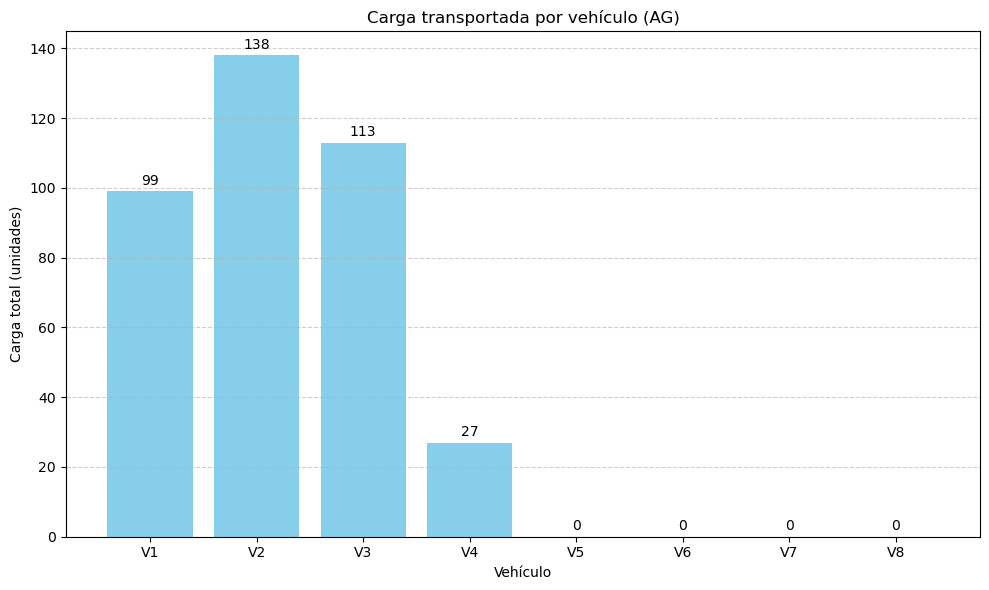

In [79]:
graficar_carga_por_vehiculo_ag(modelo_ag, nombre_figura="resultados/carga_por_vehiculo_ag_caso1.png")

In [83]:
generar_verificacion_ag_completa(modelo_ag, centros1, clientes1, vehiculos1, distancias1, parametros, geometries1, nombre_archivo="resultados/verificacion_ag_caso1.csv")

,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V1,CD1,99.0,CD1 - C1 - C4 - C15 - C21 - C7 - C19 - C3 - CD1,7,13 - 15 - 17 - 14 - 17 - 11 - 12,82.6808,198.43392,434074.200
1,V2,CD1,138.0,CD1 - C17 - C24 - C10 - C16 - C11 - C9 - C8 - ...,8,25 - 11 - 15 - 10 - 17 - 20 - 20 - 20,92.1394,221.13456,483731.850
2,V3,CD1,113.0,CD1 - C23 - C14 - C22 - C13 - C6 - C18 - C2 - CD1,7,15 - 15 - 18 - 21 - 17 - 12 - 15,72.5339,174.08136,380802.975
3,V4,CD1,27.0,CD1 - C20 - C12 - CD1,2,15 - 12,32.9386,79.05264,172927.650


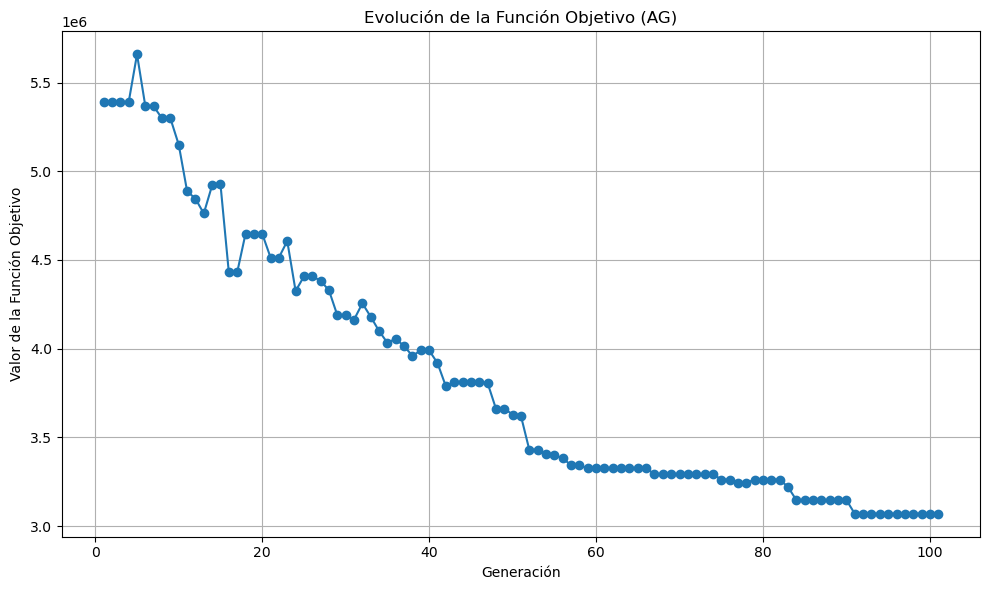

In [84]:
graficar_evolucion_ag(modelo_ag, nombre_figura="resultados/evolucion_ag_caso1.png")

### Caso 2

In [85]:
distancias2, geometries2 = calcular_distancias_y_geometrias(centros2, clientes2, get_route_info)

In [89]:
modelo_ag_2 = ModeloRuteoAG(centros2, clientes2, vehiculos2, parametros, distancias2)


start_time2 = time.time()
mem_usage2, result = memory_usage(
    (modelo_ag_2.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time2 = time.time()

print("Tiempo de ejecución:", end_time2 - start_time2, "segundos")
print("Uso máximo de memoria:", mem_usage2, "MiB")

print("Costo total:", modelo_ag_2.valor_funcion_objetivo())

for v, ruta in modelo_ag_2.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min        	avg        
0  	80    	2.21508e+06	4.73853e+06
1  	67    	2.16758e+06	2.77905e+08
2  	67    	2.16758e+06	4.147e+08  
3  	58    	2.16758e+06	1.40378e+08
4  	63    	2.16758e+06	2.77138e+08
5  	65    	1.93571e+06	1.39964e+08
6  	71    	1.93571e+06	1.40014e+08
7  	63    	1.93571e+06	2.68352e+06
8  	71    	1.93571e+06	1.39575e+08
9  	74    	1.99751e+06	2.80968e+06
10 	69    	2.02145e+06	2.6199e+06 
11 	61    	1.93571e+06	2.68837e+06
12 	68    	1.93571e+06	2.49887e+06
13 	67    	1.92067e+06	2.55956e+06
14 	65    	1.92067e+06	2.37924e+06
15 	65    	1.92067e+06	2.35114e+06
16 	63    	1.92067e+06	2.26909e+06
17 	70    	1.92067e+06	1.39092e+08
18 	71    	1.92067e+06	2.18616e+06
19 	68    	1.92067e+06	1.38982e+08
20 	62    	1.92067e+06	2.1191e+06 
21 	69    	1.92067e+06	2.00907e+06
22 	65    	1.92067e+06	1.99458e+06
23 	67    	1.92067e+06	1.97383e+06
24 	62    	1.92067e+06	1.99375e+06
25 	64    	1.92067e+06	2.05493e+06
26 	67    	1.92067e+06	1.9675e+06 
27 	66    	1.92067e+

In [90]:
visualizar_rutas_folium_ag(modelo_ag_2.obtener_rutas(), centros2, clientes2, geometries2, distancias2, nombre_archivo="resultados/mapa_rutas_ag_caso2.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso2.html'


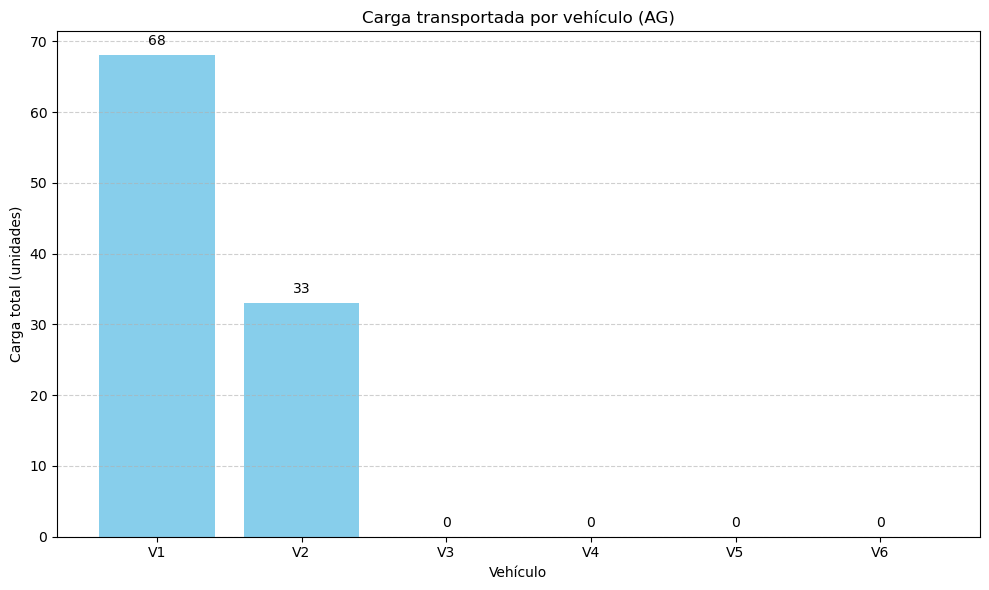

In [91]:
graficar_carga_por_vehiculo_ag(modelo_ag_2, nombre_figura="resultados/carga_por_vehiculo_ag_caso2.png")

In [93]:
generar_verificacion_ag_completa(modelo_ag_2, centros2, clientes2, vehiculos2, distancias2, parametros, geometries2, nombre_archivo="resultados/verificacion_ag_caso2.csv")

,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V1,CD6,68.0,CD6 - C6 - C9 - C7 - C8 - C5 - C3 - CD9,6,11 - 15 - 12 - 10 - 5 - 15,59.8641,143.67384,314286.525
1,V2,CD6,33.0,CD6 - C4 - C1 - C2 - CD5,3,6 - 12 - 15,24.2157,58.11768,127132.425


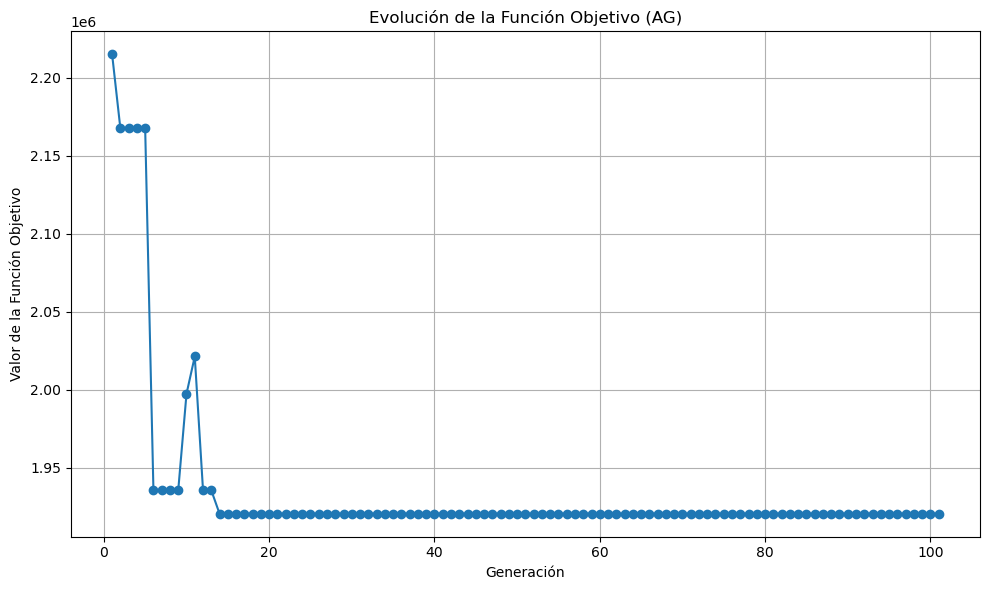

In [94]:
graficar_evolucion_ag(modelo_ag_2, nombre_figura="resultados/evolucion_ag_caso2.png")

### Caso 3

In [ ]:
distancias3, geometries3 = calcular_distancias_y_geometrias(centros3, clientes3, get_route_info)

In [62]:
modelo_ag_3 = ModeloRuteoAG(centros3, clientes3, vehiculos3, parametros, distancias3)

start_time3 = time.time()
mem_usage3, result = memory_usage(
    (modelo_ag_3.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time3 = time.time()

print("Tiempo de ejecución:", end_time3 - start_time3, "segundos")
print("Uso máximo de memoria:", mem_usage3, "MiB")

print("Costo total:", modelo_ag_3.valor_funcion_objetivo())

for v, ruta in modelo_ag_3.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min       	avg        
0  	80    	1.7473e+07	2.59994e+07
1  	69    	1.92876e+07	4.35933e+08
2  	64    	2.00542e+07	2.43502e+07
3  	65    	1.94563e+07	4.34746e+08
4  	65    	1.80195e+07	2.35915e+07
5  	69    	1.7211e+07 	1.60059e+08
6  	70    	1.81729e+07	7.07609e+08
7  	64    	1.58231e+07	1.59333e+08
8  	68    	1.58231e+07	2.95909e+08
9  	68    	1.49568e+07	2.21799e+07
10 	62    	1.49568e+07	2.07152e+07
11 	68    	1.52147e+07	2.16964e+07
12 	73    	1.52147e+07	1.59172e+08
13 	64    	1.52147e+07	1.58075e+08
14 	64    	1.52147e+07	2.1236e+07 
15 	66    	1.44613e+07	2.94683e+08
16 	70    	1.52147e+07	5.67576e+08
17 	66    	1.39617e+07	1.55788e+08
18 	66    	1.49101e+07	5.66456e+08
19 	62    	1.46335e+07	1.55389e+08
20 	71    	1.44842e+07	1.80396e+07
21 	61    	1.41592e+07	1.72499e+07
22 	64    	1.38304e+07	1.69037e+07
23 	62    	1.38388e+07	1.61197e+07
24 	65    	1.37878e+07	1.56441e+07
25 	70    	1.37609e+07	1.56264e+07
26 	66    	1.36393e+07	1.56744e+07
27 	72    	1.35474e+07

In [63]:
visualizar_rutas_folium_ag(modelo_ag_3.obtener_rutas(), centros3, clientes3, geometries3, distancias3, nombre_archivo="resultados/mapa_rutas_ag_caso3.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso3.html'


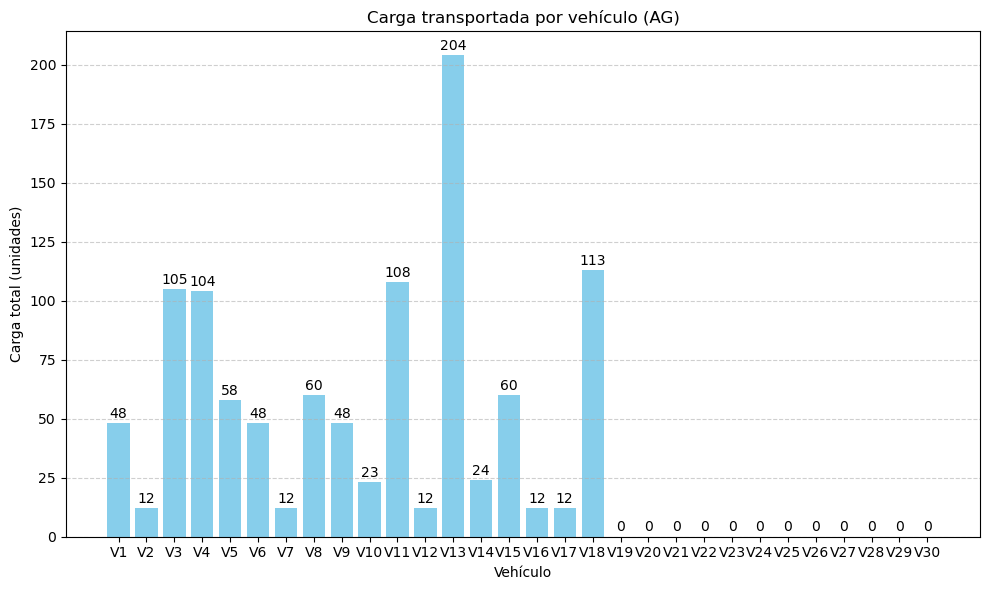

In [64]:
graficar_carga_por_vehiculo_ag(modelo_ag_3, nombre_figura="resultados/carga_por_vehiculo_ag_caso3.png")

In [ ]:
generar_verificacion_ag_completa(modelo_ag_3, centros3, clientes3, vehiculos3, distancias3, parametros, geometries3, nombre_archivo="resultados/verificacion_ag_caso3.csv")

In [ ]:
graficar_evolucion_ag(modelo_ag_3, nombre_figura="resultados/evolucion_ag_caso3.png")

## Análisis Comparativo

### Valor de Función Objetivo

| Caso   | Pyomo | AG  | Diferencia Porcentual|
|--------|-------|-----|----------------------|
| Caso 1 | 4040313 | 3069205 | 24% |
| Caso 2 | 1027503 | 1920673 | 46.5% |
| Caso 3 |       |     ||

En el caso 1, el AG mejoró un 24%

En el caso 2, Pyomo mejoró un 46.5%


### Tiempo de Ejecución

| Caso   | Pyomo | AG  |
|--------|-------|-----|
| Caso 1 | 450 s | 0.72 s |
| Caso 2 | 4.5 s | 0.5 s |
| Caso 3 |       |     |


### Uso de Memoria

| Caso   | Pyomo | AG  |
|--------|-------|-----|
| Caso 1 | 237.5 MiB | 220.5 MiB |
| Caso 2 | 257.8 MiB | 235.97 MiB |
| Caso 3 |       |     |

### Comportamientos al escalar

### Diferencias entre rutas

Para el caso 1, la solución de Pyomo utilizó los 8 vehículos mientras que el Algoritmo Genético utilizó solo 4. Las rutas de Pyomo suelen ser más cortas y con menos clientes, de forma que algunos vehículos visitan un único cliente en su recorrido. Por otra parte, los vehículos de la solución AG tienden a atender varios clientes y tener rutas más largas. 

De manera similar, la solución de Pyomo utilizó 6 vehículos para la solución del caso 2 mientras que la solución AG utilizó 2. 

*caso 3...

### Factibilidad 

La implementación de Pyomo cumple con todas las restricciones mientras que la implementación AG cumple con la mayoría de restricciones a excepción de la capacidad de los Centros de Distribución para el caso 2. 


### Distribución de Carga y Distancia Recorrida


En Pyomo, al utilizar más vehículos cada uno debe recorrer distancias menores, mientras que en la solución AG se recorren distancias más grandes con dos vehículos. El AG tiende a priorizar la reducción de la cantidad de vehículos a pesar de que esto extienda las rutas.